# 多GPU训练

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import utils

简单网络

In [2]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

向多个设备分发参数

In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params = get_params(params, utils.try_gpu(0))
print("b1 weight:", new_params[1])
print("b1 grad:", new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


allreduce函数将所有向量相加，并将结果广播给所有GPU

In [4]:
def allreduce(data):
    # data是一个list，有多少个gpu，就有多少个list
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device) #所有data求和
    for i in range(1, len(data)):
        # 重新复制过去给其他device
        data[i] = data[0].to(data[i].device)
        
data = [torch.ones((1,2), device=utils.try_gpu(i)) * (i+1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


将一个小批量数据均匀地分布在多个GPU上

In [5]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device("cuda:0"), torch.device("cuda:1")]
split = nn.parallel.scatter(data, devices) # 均匀切开给不同的device
print("input:", data)
print("load into", devices)
print("output:", split)

input: tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [6]:
def split_batch(X, y, devices):
    '''将X和Y拆分到多个设备'''
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), 
            nn.parallel.scatter(y, devices))

在一个小批量上实现多GPU训练

In [7]:
def sgd(params, lr, batch_size):
    """小批量梯度下降"""
    with torch.no_grad():
        for param in params:  # 参数b和w
            param -= lr*param.grad/batch_size
            param.grad.zero_()

In [8]:
def train_batch(X, y, device_params, devices, lr):
    '''
    device_params: 训练的参数
    devices:
    '''
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    # tensorflow能够让代码自动并行
    ls = [loss(lenet(
        X_shard, device_W), y_shard).sum() 
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)
    ]
    for l in ls:
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            # i表示第几层
            allreduce(
                [device_params[c][i].grad 
                 for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

定义训练函数

In [13]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = utils.load_data_fashion_mnist(batch_size)
    devices = [utils.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = utils.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = utils.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (utils.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.84，7.7秒/轮，在[device(type='cuda', index=0)]


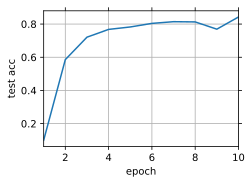

In [14]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

train(num_gpus=1, batch_size=256, lr=0.2)

测试精度：0.80，6.9秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


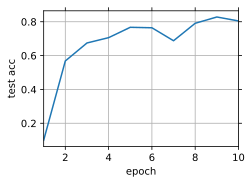

In [15]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

train(num_gpus=2, batch_size=256, lr=0.2)

# 多GPU的简洁实现

In [1]:
import torch
from torch import nn
import utils

In [2]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(utils.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(utils.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

训练

In [10]:
import pdb

In [3]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = utils.load_data_fashion_mnist(batch_size)
    devices = [utils.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    
    net.apply(init_weights)
    # 系统知道net会复制到各个gpu上，重新定义了net的forward函数
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = utils.Timer(), 10
    animator = utils.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            # 和单gpu一样
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (utils.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

In [34]:
train_iter, test_iter = utils.load_data_fashion_mnist(256)
net = resnet18(10)
devices = [utils.try_gpu(i) for i in range(2)]
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
# 系统知道net会复制到各个gpu上，重新定义了net的forward函数
net = nn.DataParallel(net, device_ids=devices)
trainer = torch.optim.SGD(net.parameters(), 0.1)

for epoch in range(10):
    net.train()
    for X, y in train_iter:
        trainer.zero_grad()
        # 和单gpu一样
        X, y = X.to(devices[0]), y.to(devices[0])
        break
    break

In [24]:
for name in net.state_dict():
    break

In [27]:
train_iter, test_iter = utils.load_data_fashion_mnist(256)

KeyboardInterrupt: 

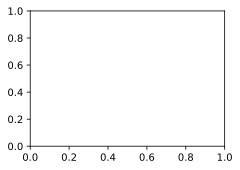

In [6]:
net = resnet18(10)
train(net, num_gpus=1, batch_size=256, lr=0.1)

测试精度：0.89，73.3秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


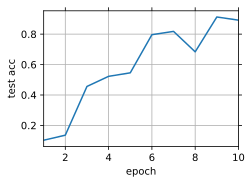

In [39]:
net = resnet18(10).cuda()
train(net, num_gpus=2, batch_size=256, lr=0.1)

测试精度：0.57，62.4秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


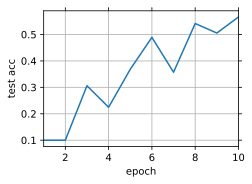

In [40]:
net = resnet18(10).cuda()
train(net, num_gpus=2, batch_size=256*2, lr=0.1*2)